<a href="https://colab.research.google.com/github/talhaanwarch/RIADD-ISBI-2021/blob/main/eye_disease_multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#connect drive with colab notebook/
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Tue Mar  2 16:33:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%%capture
pip install efficientnet_pytorch

In [4]:
%%capture
!cp '/content/drive/MyDrive/data/eye/Evaluation_Set.zip' '/content/'
!cp '/content/drive/MyDrive/data/eye/Training_Set.zip' '/content/'
!unzip '/content/Evaluation_Set.zip'
!unzip '/content/Training_Set.zip'
!rm '/content/Evaluation_Set.zip'
!rm '/content/Training_Set.zip'

In [5]:
import pandas as pd
import numpy as np

df=pd.read_csv('/content/Training_Set/RFMiD_Training_Labels.csv')
df.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
df.Disease_Risk.value_counts()

1    1519
0     401
Name: Disease_Risk, dtype: int64

In [7]:
df.ID='Training_Set/Training/'+df.ID.astype(str)+'.png'
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,Training_Set/Training/940.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Training_Set/Training/1854.png,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Training_Set/Training/594.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Training_Set/Training/868.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Training_Set/Training/56.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [8]:
test_df=pd.DataFrame(np.zeros((640,df.shape[1])))
test_df.columns=list(df.columns)
test_df.ID=range(1,641)
test_df.ID='Evaluation_Set/'+test_df.ID.astype(str)+'.png'
test_df.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,Evaluation_Set/1.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Evaluation_Set/2.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Evaluation_Set/3.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Evaluation_Set/4.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Evaluation_Set/5.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
import torch 
from torchvision import transforms 
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
import torch.nn as nn

In [10]:
aug=transforms.Compose([
                        transforms.Resize((300,300)),
                        transforms.RandomHorizontalFlip(p=1),transforms.RandomVerticalFlip(p=1),
                        transforms.RandomRotation(degrees=30),
                        
                        transforms.ToTensor(),
                        #transforms.RandomErasing(p=0.2),
                        transforms.Normalize([0.5820, 0.4512, 0.4023], [0.2217, 0.1858, 0.1705]),

                        ])

In [11]:
from PIL import Image
class dfloader(torch.utils.data.Dataset):
    
    def __init__(self,img_id,img_label,transform=None):
        self.img_id = img_id    
        self.img_label=img_label
        self.transform=transform
        
    def __getitem__(self,index):
        if type(index) == torch.Tensor:
          index = index.item()
        img_ind=self.img_id[index]
        label_ind=self.img_label[index]
        img = Image.open(img_ind).convert('RGB')
        if self.transform:
           img=self.transform(img) 
        return img ,label_ind
    
    def __len__(self):
        return len(self.img_id)


In [12]:

def effnet_model():
  model=EfficientNet.from_pretrained('efficientnet-b3')
  num_ftrs = model._fc.in_features
  model._fc = nn.Sequential(
                        nn.Linear(num_ftrs, 512), 
                        nn.ReLU(), 
                        nn.Dropout(0.5),
                        #nn.Linear(512, 256),  
                        #nn.ReLU(),
                        #nn.Dropout(0.25),
                        nn.Linear(512, 28),  
                        nn.Sigmoid(),
  )
  return model

In [13]:
from sklearn.metrics import classification_report,f1_score
from time import time


def fit_train(loader):
    loss_sum=0
    acc_sum=0
    for batch in loader:
        img,label=batch
        img,label = img.to(device),label.to(device)
        
        out=model(img)
        loss=criterion(out,label.float())
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_sum+=loss.item()        
    return loss_sum
def fit_val(loader):
    loss_sum=0
    acc_sum=0
    for batch in loader:
        img,label=batch
        img,label = img.to(device),label.to(device)
        out=model(img)
        loss=criterion(out,label.float())
        loss_sum+=loss.item()
    return loss_sum

def fit_test(loader,val=False):
  test_pred,test_actual=[],[]
  for img,label in loader:
    test_pred.append(model(img.to(device)))
    test_actual.append(label)
  test_pred=torch.cat(test_pred,dim=0)
  y_pred=test_pred.cpu().numpy()
  if val:
    test_actual=torch.cat(test_actual,dim=0)
    y_pred=y_pred.flatten()
    test_actual=test_actual.cpu().numpy().flatten()
    kappa = metrics.cohen_kappa_score(test_actual, y_pred>0.5)
    f1 = metrics.f1_score(test_actual, y_pred>0.5, average='micro')
    auc = metrics.roc_auc_score(test_actual, y_pred)
    print('kappa ',kappa,' f1 ',f1,' auc ',auc)
    return [kappa,f1,auc]
  else:
    return y_pred



def fit(train_loader,val_loader,test_loader,model,epoch=10,scheduler_step=None,verbose=None):
  
  train_loss_plt=[]
  val_loss_plt=[]
  train_acc_plt=[]
  val_acc_plt=[]
  for ep in range(epoch):
    start=time()
    #start training loop
    train_loss=fit_train(train_loader)
    #start validation loop
    model.eval()
    with torch.no_grad():
        val_loss=fit_val(val_loader)
    end=np.round((time()-start)/60,2) #time in minute
    model.train()

    #calculate print and append the results for plotting purpose
    val_avg_loss=np.round(val_loss/len(val_loader),2)#val loss of all batches of one epoch
    train_avg_loss=np.round(train_loss/len(train_loader),2)# train loss of all batches of one epoch
    if scheduler_step:
      scheduler.step(val_avg_loss)
    if verbose:
      print('Epoch {}, time {} ,  train loss {} , val loss is {}, learning rate is {} '.format
            (ep,end,train_avg_loss,val_avg_loss,opt.param_groups[0]['lr']))
    train_loss_plt.append(train_avg_loss)  #append loss of training data  
    val_loss_plt.append(val_avg_loss)     #append loss of validation data
 
 #test phase
  model.eval()
  with torch.no_grad():
     y_pred=fit_test(test_loader)
     metric=fit_test(val_loader,val=True)#5 fold
  

     

  return [train_loss_plt,val_loss_plt],y_pred,metric

In [14]:
from sklearn.model_selection import KFold,StratifiedKFold
from torch.utils.data.dataloader import DataLoader
from sklearn import metrics
device=torch.device('cuda')
classification_reports=[]
kf = KFold(n_splits=5)
graph,preds,metric_score=[],[],[]
fold=0
test=dfloader(test_df.ID.values,test_df.values[:,2::].astype(int),transform=aug)
test_loader = DataLoader(test,shuffle=False,num_workers=0,batch_size=32)


for train_index, val_index in kf.split(df.ID):
  fold_start=time()
  train=df.iloc[train_index,:]
  val=df.iloc[val_index,:]
  
  train=dfloader(train.ID.values,train.values[:,2::].astype(int),transform=aug)
  val=dfloader(val.ID.values,val.values[:,2::].astype(int),transform=aug)
  train_loader = DataLoader(train,shuffle=True,num_workers=0,batch_size=32)
  val_loader = DataLoader(val,shuffle=True,num_workers=0,batch_size=32)

  #model initiate
  model=effnet_model()
  my_model=model.to(device)
  criterion =  nn.BCELoss()
  opt=torch.optim.AdamW(params=my_model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode ='min',factor=0.5, patience=4, verbose=True)
  #training
  res=fit(train_loader,val_loader,test_loader,my_model,epoch=5,scheduler_step=True,verbose=True)
  graph.append(res[0]),preds.append(res[1]),metric_score.append(res[2])
  fold+=1
  del my_model
  print('-----------fold {}--------------{}'.format(fold,np.round(time()-fold_start)/60))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth



Loaded pretrained weights for efficientnet-b3
Epoch 0, time 4.87 ,  train loss 0.18 , val loss is 0.19, learning rate is 0.001 
Epoch 1, time 4.88 ,  train loss 0.11 , val loss is 0.14, learning rate is 0.001 
Epoch 2, time 4.85 ,  train loss 0.09 , val loss is 0.14, learning rate is 0.001 
Epoch 3, time 4.86 ,  train loss 0.08 , val loss is 0.12, learning rate is 0.001 
Epoch 4, time 4.87 ,  train loss 0.07 , val loss is 0.11, learning rate is 0.001 
kappa  0.5203240529254105  f1  0.9712611607142857  auc  0.9374751508040032
-----------fold 1--------------26.7
Loaded pretrained weights for efficientnet-b3
Epoch 0, time 4.9 ,  train loss 0.18 , val loss is 0.12, learning rate is 0.001 
Epoch 1, time 4.9 ,  train loss 0.11 , val loss is 0.18, learning rate is 0.001 
Epoch 2, time 4.9 ,  train loss 0.1 , val loss is 0.16, learning rate is 0.001 
Epoch 3, time 4.89 ,  train loss 0.09 , val loss is 0.13, learning rate is 0.001 
Epoch 4, time 4.9 ,  train loss 0.08 , val loss is 0.13, learn

In [21]:
pred.shape

(640, 28)

In [23]:
pred=np.mean(np.array(preds),axis=0)
pred_df=pd.DataFrame(pred)
pred_df.to_csv('/content/drive/MyDrive/data/eye/bi_label.csv',index=False)

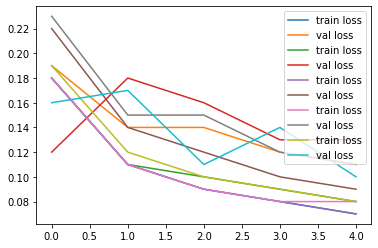

In [28]:
import matplotlib.pyplot as plt
for i in range(5):
  plt.plot(graph[i][0],label='train loss')
  plt.plot(graph[i][1],label='val loss')
plt.legend()